In [1]:
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
INPUT_NAME = ('connectivities'
              '_classifier-SVM'
              '_measure-accuracy'
              '_shap-enabled'
              '_agg-network'
              '_top-15'
              '_cv-100x4fold')

RESULTS = xr.open_dataset(f'models/{INPUT_NAME}.nc5', engine='scipy').load()
TOP_MODEL_NAMES = [name for name in RESULTS['grid_model_name'].values[:3]]
# top_model_scores = scores.query('label in @top_model_names').sort_values('mean_test_score')
MODEL_COLORS = ['#1BA1E2', '#6A00FF', '#D80073', 'orange', 'black', 'red']
pallete = sns.color_palette(MODEL_COLORS)

RESULTS

<xarray.Dataset>
Dimensions:                                                 (shap_dim: 800,
                                                             difumo64_networks_feature: 136,
                                                             gordon2014_networks_feature: 78,
                                                             dosenbach2010_networks_feature: 21,
                                                             permutation_importance_num: 500,
                                                             subject: 32,
                                                             grid_model_name: 15,
                                                             y_classes: 2)
Coordinates:
  * difumo64_networks_feature                               (difumo64_networks_feature) object ...
  * gordon2014_networks_feature                             (gordon2014_networks_feature) object ...
  * dosenbach2010_networks_feature                          (dosenbach2010_networks_feature) object ...
  * grid_model_name                                         (grid_model_name) object ...
  * y_classes                                               (y_classes) object ...
Dimensions without coordinates: shap_dim, permutation_importance_num, subject
Data variables: (12/191)
    difumo64_networks_precision shap                        (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_precision shap data                   (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap              (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_partial-correlation shap data         (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_correlation shap                      (shap_dim, difumo64_networks_feature) float64 ...
    difumo64_networks_correlation shap data                 (shap_dim, difumo64_networks_feature) float64 ...
    ...                                                      ...
    std_test_score                                          (grid_model_name) float64 ...
    rank_test_score                                         (grid_model_name) int32 ...
    scoring                                                 object 'accuracy'
    cv_test_size                                            int32 8
    cv_n_splits                                             int32 100
    n_subjects                                              int32 32

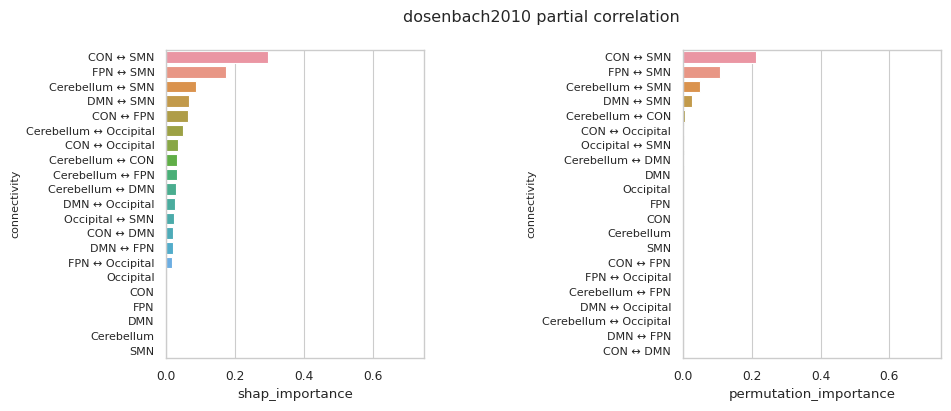

In [126]:
def clean_network_labels(label):
    new_label = (label.replace('None', 'unassigned')
                      .replace('cingulo-opercular', 'CON')
                      .replace('fronto-parietal', 'FPN')
                      .replace('fonto-parietal', 'FPN')
                      .replace('cerebellum', 'Cerebellum')
                      .replace('occipital', 'Occipital')
                      .replace('sensorimotor', 'SMN')
                      .replace('CinguloOperc', 'CON')
                      .replace('default', 'DMN')
                      .replace('SMhand', 'SMN (hand)')
                      .replace('SMmouth', 'SMN (mouth)')
                      .replace('VentralAttn', 'VAN')
                      .replace('DorsalAttn', 'DAN')
                      .replace('DefaultMode', 'DMN')
                      .replace('Default', 'DMN')
                      .replace('Salience', 'SN')
                      .replace('RetrosplenialTemporal', 'RSTC')
                      .replace('CinguloParietal', 'CPN')
                      .replace('FrontoParietal', 'FPN')
    )
    return new_label

def plot_shap(model_name, ax):
    shap_key = f'{model_name} shap'
    shap_df = RESULTS[shap_key].to_dataframe().reset_index()
    shap_df.columns = ['shap_dim', 'feature', 'shap_importance']
    shap_df['feature'] = shap_df['feature'].apply(clean_network_labels)
    shap_df['shap_importance'] = shap_df['shap_importance'].abs()
    shap_df = shap_df.groupby('feature').mean().sort_values('shap_importance', ascending=False).reset_index()
    sns.barplot(data=shap_df, y='feature', x='shap_importance', orient='h', label=model_name, ax=ax)
    ax.set_xlim(0, .75)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_ylabel('connectivity', fontsize='small')

def plot_feature_importance(model_name, ax):
    imp_df = RESULTS[f'{model_name} importances'].to_dataframe().reset_index()
    imp_df = imp_df.sort_values(f'{model_name} importances', ascending=False)
    imp_df.columns = ['perm_dim', 'feature', 'permutation_importance']
    imp_df['feature'] = imp_df['feature'].apply(clean_network_labels)
    imp_df = imp_df.groupby('feature').mean().sort_values('permutation_importance', ascending=False).reset_index()
    sns.barplot(data=imp_df,
                y='feature', x='permutation_importance',
                orient='h',
                capsize=.3,
                errwidth=1,
                ax=ax)
    ax.set_xlim(0, .75)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_ylabel('connectivity', fontsize='small')

sns.set_theme('paper', 'whitegrid')
model_name = 'dosenbach2010_networks_partial-correlation'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4),
                               gridspec_kw={'wspace': 1},
                               sharex=False, sharey=False)
plot_shap(model_name, ax1)
plot_feature_importance(model_name, ax2)
plt.suptitle(model_name.replace('_networks_',' ').replace('-',' ').replace('_',' '))
plt.show()
